# Neural Network back propagation

**神经网络反向传播**

上次通过分类的one vs all的方法实现了，对每一个label都训练了一个逻辑回归。

这次将使用反向传播的前馈神经网络
- 通过反向传播算法实现神经网络成本函数和梯度计算的非正则化和正则化版本
- 实现随即权重初始化和使用网络进行预测的方法

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat


## Visualizing the data

In [2]:
def load_data(path):
    data = loadmat(path)
    X = data['X']
    y = data['y']

    return X, y

In [3]:
# load Data
X_raw, y_raw = load_data('ex4data1.mat')
X_raw.shape, y_raw.shape

((5000, 400), (5000, 1))

In [4]:
def plot_image(X):
    sz = int(np.sqrt(X.shape[1]))
    sample_idx = np.random.choice(np.arange(X.shape[0]), 100)
    sample_images = X[sample_idx, :]

    row,col = 5, 5

    fig, axs = plt.subplots(nrows=row, ncols=col, sharey=True, sharex=True,
                            figsize=(5,5))
    for r in range(row):
        for c in range(col):
            axs[r, c].matshow(sample_images[10 * r + c].reshape((sz, sz)),
                              cmap='binary')
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))
    plt.show()

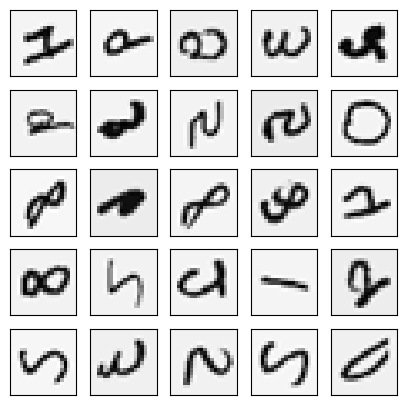

In [5]:
plot_image(X_raw)

我们要为此联系构建的神经网络具有与我们的实例数据(400+偏置单元)大小匹配的输入层，25个单元的隐藏层（带有偏置单元的26个)，以及一个输出层。10个单位对应我们的一个one-hot编码类标签。

对y标签进行[Ont-Hot Encoding](https://zhuanlan.zhihu.com/p/134495345)。

One-Hot Encoding 简而言之将类标签n(k类)转换为长度为k的向量，其中索引n为 `hot(1)`,其余为0

In [6]:
from sklearn.preprocessing import OneHotEncoder

def one_hot_encoding(y):
    encoder = OneHotEncoder(sparse_output=False)

    y_onehot = encoder.fit_transform(y)
    return y_onehot

In [7]:
X = X_raw
y = one_hot_encoding(y_raw)
y_raw.shape, y.shape

((5000, 1), (5000, 10))

In [8]:
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## Feedforward 前向传播

已经给出训练得到的$\theta_1,\theta_2$，通过前向传播计算得到预测结果

### 前向传播函数

$$(400 + 1) \rightarrow (25 + 1) \rightarrow (10)$$

<img src="img.png" style="margin:auto">

a1 (N, input_s + 1)

theta1 (hidden_s, input_s + 1)

z2 (N, hidden_s)

a2 (N, hidden_s + 1)

theta2 (n_label = 10, hidden_s + 1)

z3 (N, n_label=10)

$$
z^2 = a_1 {\theta^1}^T
$$
$$
a^1\stackrel{\theta^1}{\rightarrow}\ z^2 \stackrel{sigmoid}{\rightarrow} a^2 \stackrel{\theta^2}{\rightarrow}\ z^3 \stackrel{sigmoid}{\rightarrow} h
$$

#### 载入$\Theta$

In [9]:
# load weight
def load_weigth(path):
    data = loadmat(path)
    return data['Theta1'], data['Theta2']

In [10]:
t1, t2 = load_weigth('ex4weights.mat')
t1.shape, t2.shape

((25, 401), (10, 26))

#### Function forward_propagation

In [11]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def serialize(theta1, theta2):
    return np.concatenate([theta1.ravel(), theta2.ravel()])

def deserialized(ser, input_size=400, hidden_size=25, label_size=10):
    size = (input_size + 1) * hidden_size
    return (ser[:size].reshape(hidden_size, input_size + 1),
            ser[size:].reshape(label_size, hidden_size + 1))

In [12]:
theta_combine = serialize(t1, t2)
# th1, th2 = deserialized(theta_combine, X_raw.shape[1], t1.shape[0], 10)
th1, th2 = deserialized(theta_combine)
theta_combine.shape, th1.shape, th2.shape


((10285,), (25, 401), (10, 26))

In [13]:
def forward_propagation(X, theta, input_size=400, hidden_size=25, label_size=10):

    theta1, theta2 = deserialized(theta, input_size, hidden_size, label_size)
    m = X.shape[0]

    a1 = np.insert(X, 0, values=np.ones(m), axis=1)

    z2 = a1 @ theta1.T
    a2 = np.insert(sigmoid(z2), 0, values=np.ones(m), axis=1)

    z3 = a2 @ theta2.T
    h = sigmoid(z3)
    return a1, z2, a2, z3, h

In [14]:
# a1, z2, a2, z3, h = forward_propagation(X, theta_combine)

In [15]:
# h   # (5000, 10)

In [16]:
# a1.shape, z2.shape, a2.shape, z3.shape
# # (5000, 401), (5000, 25), (5000, 26), (5000, 10)

## Cost Function

$$
J(\theta) = \frac{1}{m} \sum_{i=1}^{m} \sum_{k=1}^{K} \left[
    -y_{k}^{(i)} \log\left( h_{\theta}(x^{(i)})_{k} \right)
    - \left(1 - y_{k}^{(i)}\right) \log\left(1 - \left( h_{\theta}(x^{(i)}) \right)_{k} \right)
\right]
$$

In [59]:
def nn_cost(theta, X, y, input_size=400, hidden_size=25, label_size=10):
    h = forward_propagation(X, theta, input_size, hidden_size, label_size)[-1]
    # 添加极小值 epsilon 防止 log(0)
    epsilon = 1e-10  # 典型值为 1e-10 到 1e-7
    h_clipped = np.clip(h, epsilon, 1 - epsilon)

    tmp = -y * np.log(h_clipped) - (1-y) * np.log(1-h_clipped)

    return tmp.sum() / len(X)

In [60]:
nn_cost(theta_combine, X, y)

np.float64(0.2876291651613189)

## Regularized cost function

$$
J(\theta) =
\frac{1}{m} \sum_{i=1}^{m} \sum_{k=1}^{K} \left[
    -y_{k}^{(i)} \log\left( h_{\theta}(x^{(i)})_{k} \right)
    - \left(1 - y_{k}^{(i)}\right) \log\left(1 - h_{\theta}(x^{(i)})_{k} \right)
\right] $$ $$ + \frac{\lambda}{2m} \left[ \sum_{j=1}^{25} \sum_{k=1}^{400} \left( \Theta^{(1)}_{j,k} \right)^2 + \frac{25}{2m} \sum_{j=1}^{10} \sum_{k=1}^{25} \left( \Theta^{(2)}_{j,k} \right)^2 \right]
$$

In [19]:
def nn_cost_reg(theta, X, y, input_size=400, hidden_size=25, label_size=10, lambda_=1):
    theta1, theta2 = deserialized(theta, input_size, hidden_size, label_size)
    reg = np.sum(theta1[:, 1:] ** 2) + np.sum(theta2[:, 1:] ** 2)
    return nn_cost(theta, X, y, input_size, hidden_size, label_size) + lambda_ * reg / (2 * len(X))

In [20]:
nn_cost_reg(theta_combine, X, y)

np.float64(0.38376985909092365)

## Backpropagation

Backpropagation is a gradient estimation method comminly used for trainning a NN to compute its _**parameter updates**_

### Sigmoid gradient

$$
g^{'}(z) = \frac{d}{dz}g(z)=g(z)(1-g(z))
$$

For large values (both positive and negative) of z, the gradient should be close to 0;

When z = 0, the gradient should be exactly 0.25.

In [21]:
def sigmoid_gradient(z):
    return sigmoid(z) * (1 - sigmoid(z))

In [22]:
sigmoid_gradient(0)

np.float64(0.25)

### Backpropogation

<img src="img_1.png" style="margin:auto">

反向传播参数更新计算将减少训练数据上的误差。


权重梯度计算步骤
$$
\Delta^{(l)} := \Delta^{(l)} + \delta^{(l+1)} \left( a^{(l)} \right)^T
$$

反向传播完整步骤（简版）
1. 计算输出层误差：
$$
\delta^{(L)} = a^{(L)} - y
$$

2. 反向传播至隐藏层：
$$
\delta^{(l)} = \left( \Theta^{(l)} \right)^T \delta^{(l+1)} \odot g'\left( z^{(l)} \right)
$$

3. 累积权重梯度：
$$
\Delta^{(l)} := \Delta^{(l)} + \delta^{(l+1)} \left( a^{(l)} \right)^T
$$

4. 最终梯度（含正则化项）：
$$
\frac{\partial J}{\partial \Theta^{(l)}} = \frac{1}{m} \Delta^{(l)} + \frac{\lambda}{m} \Theta^{(l)}
$$

In [23]:
def gradient(theta, X, y, input_size=400, hidden_size=25, label_size=10):

    theta1, theta2 = deserialized(theta, input_size, hidden_size, label_size)
    a1, z2, a2, z3, h = forward_propagation(X, theta, input_size, hidden_size, label_size)

    # 向量化，全矩阵计算

    # 计算输出层误差
    d3 = h - y

    # 反向传播至隐藏层
    d2 = d3 @ theta2[:, 1:] * sigmoid_gradient(z2)  # (5000, 10) @ (10, 25) * (5000, 25)

    # 显式归一化
    delta2 = (d3.T @ a2) / len(X)
    delta1 = (d2.T @ a1) / len(X)
    return serialize(delta1, delta2)

In [24]:
# detal_ = gradient(theta_combine,X, y)
# detal_.shape

####  正则梯度

In [55]:
def gradient_reg(theta, X, y, input_size=400, hidden_size=25, label_size=10, lambda_=1):
    theta1, theta2 = deserialized(theta, input_size, hidden_size, label_size)
    delta1, delta2 = deserialized(gradient(theta, X, y), input_size, hidden_size, label_size)

    m = len(X)

    # 已经在计算梯度的时候缩放过了
    # delta1 *= 1 / m
    # delta2 *= 1 / m

    delta1[:, 1:] += lambda_ * theta1[:, 1:] / m
    delta2[:, 1:] += lambda_ * theta2[:, 1:] / m
    return serialize(delta1, delta2)

In [26]:
# Delta1, Delta2 = deserialized(gradient_reg(theta_combine, X, y))
# Delta1.shape, Delta2.shape

### Gradient checking

在你的神经网络中，你正在最小化cost function $J(\Theta)$. 为了在你的参数上运行gradient checking，你要想象一个展开的参数$\Theta^{(1)},\Theta^{(2)}$，到一个长向量$\theta$中。

参数扰动定义  $\epsilon = 10^{-4}$
$$
\theta^{(i+)} = \theta + \epsilon \mathbf{e}_i, \quad
\theta^{(i-)} = \theta - \epsilon \mathbf{e}_i
$$
其中 $\mathbf{e}_i$ 是标准基向量：
$$
\mathbf{e}_i = \begin{bmatrix} 0 \\ \vdots \\ 1 \\ \vdots \\ 0 \end{bmatrix} \quad (\text{第}i\text{个元素为1})
$$

数值梯度计算
$$
f_i(\theta) \approx \frac{\partial J(\theta)}{\partial \theta_i} \approx \frac{J(\theta^{(i+)}) - J(\theta^{(i-)})}{2\epsilon}
$$

In [27]:
def gradient_check(theta, X, y, input_size=400, hidden_size=25, label_size=10,
                   epsilon=1e-4, regularized=False, lambda_=1):
    def cost_wrapper(theta_wrapper):
        return nn_cost_reg(theta_wrapper, X, y,input_size, hidden_size, label_size, lambda_) \
            if regularized else nn_cost(theta_wrapper, X, y,input_size, hidden_size, label_size)
    analytic_grad = gradient_reg(theta, X, y,input_size, hidden_size, label_size, lambda_) \
        if regularized else gradient(theta, X, y, input_size, hidden_size, label_size)
    numerical_grad = np.zeros_like(theta)

    for i in range(len(theta)):
        theta_plus = theta.copy()
        theta_plus[i] += epsilon
        theta_minus = theta.copy()
        theta_minus[i] -= epsilon
        numerical_grad[i] = (cost_wrapper(theta_plus) - cost_wrapper(theta_minus)) / (2 * epsilon)

    diff = (np.linalg.norm(numerical_grad - analytic_grad)
            / (np.linalg.norm(numerical_grad + analytic_grad) + 1e-10))
    print(f'Relative Difference: {diff}')

In [42]:
gradient_check(theta_combine, X, y, regularized=False)

Relative Difference: 2.1458659179723567e-09


In [44]:
gradient_check(theta_combine, X, y, regularized=True)

Relative Difference: 3.1902524789494973e-09


###  Random initialization

在训练神经网络时，参数的随机初始化对打破对称性至关重要。一种有效的随机初始化策略是：将参数$\Theta^{(l)}$的值均匀分布在区间$\left[-\epsilon_{init}, +\epsilon_{init} \right]$内(建议取$\epsilon_{init}=0.12$)。此取值范围既能确保参数保持较小值，又能显著提升学习效率。

In [46]:
def random_init(size, epsilon=0.12):
    '''
    生成范围在[-epsilon, epsilon]的均匀分布随机数组。
    :param size:
    :param epsilon:
    :return:
    '''
    return np.random.uniform(-epsilon, epsilon, size)

In [63]:
import scipy.optimize as opt

def nn_training(theta, X, y):
    init_theta = random_init(len(theta))

    res = opt.minimize(fun=nn_cost_reg, x0 = init_theta,
                      args=(X, y, 400, 25, 10, 1), method='TNC',
                      jac=gradient_reg)
    return res

In [62]:
res = nn_training(theta_combine, X, y) # 慢
res

(10285,)


 message: Converged (|f_n-f_(n-1)| ~= 0)
 success: True
  status: 1
     fun: 0.29974065435209646
       x: [ 1.607e-01  3.764e-12 ... -2.252e+00 -1.433e+00]
     nit: 90
     jac: [ 1.019e-06  7.528e-16 ... -2.367e-08 -1.078e-07]
    nfev: 2175

In [64]:
final_theta = res.x
final_theta

array([ 1.60726745e-01,  3.76375320e-12,  5.52016766e-12, ...,
       -9.77459665e-02, -2.25236159e+00, -1.43335127e+00])

In [65]:
from sklearn.metrics import classification_report

h = forward_propagation(X, theta_combine)[-1]
y_pred = np.argmax(h, axis=1) + 1
print(classification_report(y_raw, y_pred))


              precision    recall  f1-score   support

           1       0.97      0.98      0.98       500
           2       0.98      0.97      0.98       500
           3       0.98      0.96      0.97       500
           4       0.97      0.97      0.97       500
           5       0.97      0.98      0.98       500
           6       0.98      0.99      0.98       500
           7       0.98      0.97      0.97       500
           8       0.98      0.98      0.98       500
           9       0.97      0.96      0.96       500
          10       0.98      0.99      0.99       500

    accuracy                           0.98      5000
   macro avg       0.98      0.98      0.98      5000
weighted avg       0.98      0.98      0.98      5000



## Visualizing the hidden layer

In [66]:
def plot_hidden_layer(theta):
    theta1, theta2 = deserialized(theta)

    row,col = 5, 5

    hidden_layer = theta1[:, 1:]
    fig, ax_array = plt.subplots(nrows=row, ncols=col, sharey=True, sharex=True, figsize=(5,5))
    for r in range(row):
        for c in range(col):
            ax_array[r, c].matshow(hidden_layer[5*r+c].reshape((20,20)),
                                  cmap='binary')
            plt.xticks(np.array([]))
            plt.yticks(np.array([]))
    plt.show()

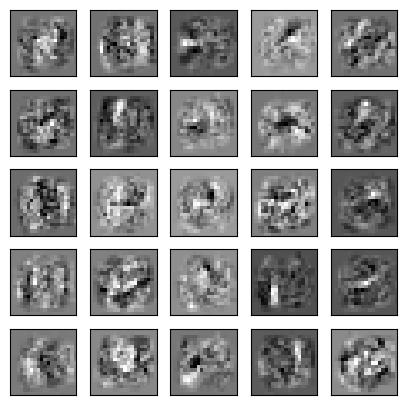

In [67]:
plot_hidden_layer(final_theta)